# Индуктивная статистика
Максим Сахаров

2023-07-28

**Статистический вывод** (англ. statistical inference), также называемый **индуктивной статистикой** (англ. inferential statistics, inductive statistics) — обобщение информации из выборки для получения представления о свойствах генеральной совокупности.

In [105]:
#!pip install statsmodels
#!'/usr/bin/python3' -m pip install scikit-posthocs

In [104]:
import numpy as np
import scipy.stats as st
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import tt_solve_power

## Доверительные интервалы

### Расчет по формуле

**Пример** По данным 7 измеренией некоторой величины найдены средняя результатов измерений, равная 30 и выборочная дисперсия, равная 36.
Найдите границы, в которых с надежностью 0,95 заключено истинное значение измеряемой выличины.

In [3]:
n = 7
dof = n - 1 # число степеней свободы
mn = 30 # среднее значение
sigma = np.sqrt(36) # Стандартное отклонение
T = 2.45 # Параметр t распределения (взят из таблицы)

In [4]:
delta = sigma * T / np.sqrt(n)

In [5]:
CI = (mn - delta, mn + delta)
CI

(24.44392224676436, 35.55607775323564)

### Собственная функция
Вспомогательная функция для подсчета доверительного интервала для маленьких выборок (до 30 элементов, t-распределение).

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = np.mean(data), st.sem(data) # sem() возвращает стандартную ошибку среднего (standart error of the mean)
    h = se * st.t.ppf((1 + confidence) / 2, n-1)  # ppf() возвращает перцентиль
    return m - h, m, m + h

standart error of the mean  ==  sigma / np.sqrt(n)

In [7]:
a = [5, 7, 7, 9, 10, 16, 7, 14, 13, 15, 16, 15, 16, 17, 18, 13, 14, 15, 6, 13, 14, 12, 13]

print(mean_confidence_interval(a, 0.60))
print(mean_confidence_interval(a, 0.90))
print(mean_confidence_interval(a, 0.99))

(11.707199792530355, 12.391304347826088, 13.07540890312182)
(11.02260721314349, 12.391304347826088, 13.760001482508686)
(10.1445373309875, 12.391304347826088, 14.638071364664675)


### Встроенные функции scipy.stats

#### Расчет с использованием нормального расеределения

Длина выборки более 30 элементов

**Пример** Используем выборку размером n = 100 и определим 90% и 99% доверительные интервалы, используя нормальное расеределение.

In [8]:
np.random.seed(54)
# Генерируем случайное множество с нормальным респределением, где среднее = loc, а стандартное отклонение = scale
dataN = st.norm.rvs(loc=25, scale=5, size=100)

In [9]:
dataN

array([15.73894628, 19.59500504, 25.39281913, 18.22932204, 28.1307423 ,
       28.66693776, 17.64510722, 16.62290224, 27.91513782, 21.61269469,
       28.38777594, 25.92764723, 19.2158274 , 20.90224588, 20.48267271,
       22.35407158, 23.12972966, 23.19403118, 21.09564881, 37.54233791,
       17.18218648, 23.84161045, 24.528124  , 30.7750649 , 28.1228123 ,
       20.52654617, 24.38654952, 31.70598737, 22.96965371, 16.83108847,
       24.31890254, 17.69496754, 22.01306736, 22.63197483, 22.29777635,
       22.74654808, 25.72601767, 27.66558128, 28.04881113, 26.8546621 ,
       28.20893056, 30.76199044, 26.6411325 , 29.08380767, 25.60118661,
       22.89269323, 23.07748028, 33.96101816, 30.31506597, 28.07265045,
       22.59758109, 22.78986482, 28.81509163, 28.63861627, 19.79342847,
       15.38874649, 20.06079634, 27.62294262, 17.28963417, 32.97260519,
       27.72269413, 29.18532255, 24.5306575 , 22.62871331, 16.02477374,
       23.83769765, 23.29590212, 23.63300021, 28.20716716, 20.11

In [10]:
ci_lower, ci_upper = st.norm.interval(confidence=0.90, loc=np.mean(dataN), scale=st.sem(dataN))
print(f'Мы уверены на 90%, что истинное среднее значение генеральной совокупности находится в диапазоне между {ci_lower:5.3f} и {ci_upper:5.3f}')

Мы уверены на 90%, что истинное среднее значение генеральной совокупности находится в диапазоне между 23.677 и 25.221


In [11]:
ci_lower, ci_upper = st.norm.interval(confidence=0.99, loc=np.mean(dataN), scale=st.sem(dataN))
print(f'Мы уверены на 99%, что истинное среднее значение генеральной совокупности находится в диапазоне между {ci_lower:5.3f} и {ci_upper:5.3f}')

Мы уверены на 99%, что истинное среднее значение генеральной совокупности находится в диапазоне между 23.240 и 25.658


#### Рассчет с использованием t распределения
Длина выборки менее 30 элементов

**Пример** Используем выборку размером n = 20 и определим 90% и 99% доверительные интервалы, используя t распределение

In [12]:
np.random.seed(54)
# Генерируем случайное множество с нормальным респределением, где среднее = loc, а стандартное отклонение = scale
dataT = st.norm.rvs(loc=25, scale=5, size=20)

In [13]:
dataT

array([15.73894628, 19.59500504, 25.39281913, 18.22932204, 28.1307423 ,
       28.66693776, 17.64510722, 16.62290224, 27.91513782, 21.61269469,
       28.38777594, 25.92764723, 19.2158274 , 20.90224588, 20.48267271,
       22.35407158, 23.12972966, 23.19403118, 21.09564881, 37.54233791])

In [14]:
ci_lower, ci_upper = st.t.interval(confidence=0.90, df=len(dataT)-1, loc=np.mean(dataT), scale=st.sem(dataT))
print(f'Мы уверены на 90%, что истинное среднее значение генеральной совокупности находится в диапазоне между {ci_lower:4.3f} и {ci_upper:4.3f}')

Мы уверены на 90%, что истинное среднее значение генеральной совокупности находится в диапазоне между 21.057 и 25.121


In [15]:
ci_lower, ci_upper = st.t.interval(confidence=0.99, df=len(dataT)-1, loc=np.mean(dataT), scale=st.sem(dataT))
print(f'Мы уверены на 99%, что истинное среднее значение генеральной совокупности находится в диапазоне между {ci_lower:4.3f} и {ci_upper:4.3f}')

Мы уверены на 99%, что истинное среднее значение генеральной совокупности находится в диапазоне между 19.727 и 26.451


## Определение размера выборки

**Пример** Журналист в 2016 году в предверии выборов в США хочет по результатам своих исследований достаточно точно определить, кто победит на этих выборах. Сколько ему необходимо опросить людей, чтобы назвать будущего президента с точностью в 95%?

Результат предшествующих исследований свидетельствуют, что стандартное отклонение генеральной совокупности приблизительно равно 15.
Пусть погрешность измерений дельта = 5. Таким образом, обозначим стандартное отклонение сигма = 15 и квантиль нормального распределения Z = 1,96

In [16]:
sigma = 15
Z = 1.96
Delta = 5

In [17]:
N = int(np.ceil(((sigma * Z) / Delta)** 2))
N

35

In [18]:
Delta = 1
N = int(np.ceil(((sigma * Z) / Delta)** 2))
N

865

**Пример** Часто бывают ситуации, когда размер выборки может зависеть от оценки размера генеральной совокупности. Например, если мы хотим провести опрос клиентов банка на предмет удобства или качества обслуживания. Неужели размер выборки удет одинаковый если у нас 10_000 клиентов или 1_000_000 клиентов?

В этом случае для определения размера выборки можно использовать оценку размера генеральной сосоккупности о следующей формуле:

In [19]:
p = 0.5 # распределение голосов
Ddec = Delta / 100
Pop = 10000 # оценка размера генеральной совокупности

In [20]:
int(np.ceil((Z ** 2 * p * (1 - p) / Ddec ** 2) / (1 + (Z ** 2 * p * (1 - p) / (Pop * Ddec ** 2)))))

4900

In [21]:
Pop = 1000000
int(np.ceil((Z ** 2 * p * (1 - p) / Ddec ** 2) / (1 + (Z ** 2 * p * (1 - p) / (Pop * Ddec ** 2)))))

9513

## Статистическая проверка гипотез при сравнении двух выборок

### Параметрические тесты

#### Тест Стьюдента

Проверка среднего значения двух выборок или одной выборки с целевым значением

Допущешия
- Наблюдение внутри каждой выборки независимы друг от друга.
- Распределение данных нормальное или близкое к нормальному. Можно применять для других распределений, но осторожно.
- Одинаковая вариация в выборках.

Гипотеза
- Н0: Средние выборок одинаковы / Среднее выборки совпадает с целевым значением
- Н1: Средние выборок раздичаются / Среднее выборки отличается от целевого значения

**Одновыборочный тест**

**Пример** Тест покажет нам, отличаются ли средние значения выборки и генеральной совокупности (сравниваем с генеральной). Рассмотрим некоторое количество голосующих из Индии и население всего Мира. Отличается ли средний возраст избирателей Индии от возраста населения?

In [22]:
np.random.seed(54)

population_ages1 = st.norm.rvs(loc=20, scale=45, size=15000)
population_ages2 = st.norm.rvs(loc=20, scale=10, size=10000)
population_ages = np.concatenate((population_ages1, population_ages2)) # Сгенерировали всю популяцию.

india_ages1 = st.norm.rvs(loc=19, scale=65, size=2000)
india_ages2 = st.norm.rvs(loc=19, scale=55, size=2000)
india_ages = np.concatenate((india_ages1, india_ages2))

In [23]:
print('Средний возраст всего мира', population_ages.mean())
print('Средний возраст индусов', india_ages.mean())

Средний возраст всего мира 19.87059878444056
Средний возраст индусов 20.815033188073294


In [24]:
# используем одновыборочный тест Стьюдента
stat, p = st.ttest_1samp(a=india_ages, popmean=population_ages.mean())
print(f'Статистика = {stat:.3f}, p = {p:.3f}')

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средний возраст в Индии, вероятно, не отличается от среднего по миру')
else:
    print('Отклоняем нулевую гипотезу, средний возраст в Индии, вероятно, отличается от среднего по миру')

Статистика = 0.995, p = 0.320
Не отклоняем нулевую гипотезу, средний возраст в Индии, вероятно, не отличается от среднего по миру


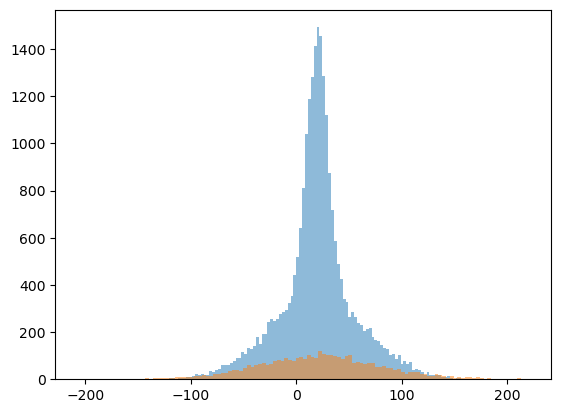

In [25]:
plt.hist(population_ages, bins=120, alpha=0.5);
plt.hist(india_ages, bins=120, alpha=0.5);

**Тест для двух выборок**

**Пример** Такой тест показывает, имеют ли две выборки разные средние значения. Здесь нулевая гипотеза заключается в том, что обе группы имеют равные средние.

In [26]:
np.random.seed(54)

# Генерируем случайное множество с нормальным распределением, где среднее = loc, а стандартное отклонение = scale
data1 = st.norm.rvs(loc=50, scale=10, size=100)
data2 = st.norm.rvs(loc=40, scale=15, size=100)

In [27]:
# Используем тест Стьюдента для двух выборок
stat, p = st.ttest_ind(data1, data2)

print(f'Статистика = {stat:.5f}, p = {p:.10f}')

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, срудние, вероятно, различаются')

                                      

Статистика = 4.28499, p = 0.0000285042
Отклоняем нулевую гипотезу, срудние, вероятно, различаются


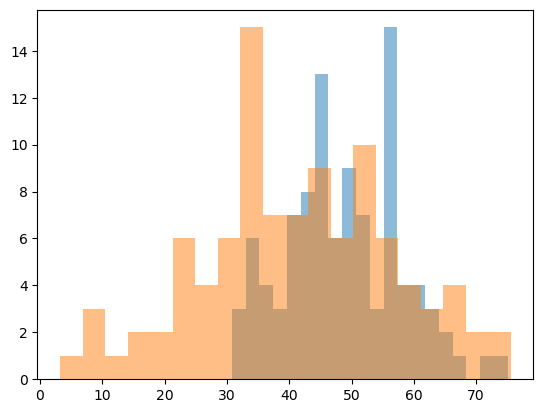

In [28]:
plt.hist(data1, bins=20, alpha=0.5);
plt.hist(data2, bins=20, alpha=0.5);

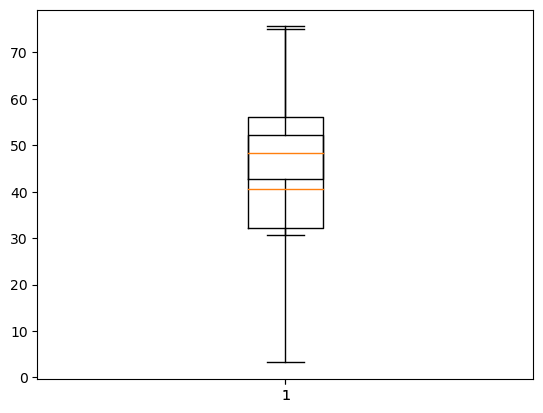

In [29]:
plt.boxplot(data1);
plt.boxplot(data2);

**Тест Левена**

In [30]:
# Используем тест Левена для проверки равенства дисперсий двух групп
def check_variance(group1, group2):
    stat, p = st.levene(group1, group2)
    print(f"p = {p:.5}")
    if p < 0.05:
        print('Отклоняем нулевую гипотезу >> Вариация в группах различается')
    else:
        print('Не отклоняем нулевую гипотезу >> Вариация в группах одинаковая')

In [31]:
check_variance(data1, data2)

p = 5.3603e-06
Отклоняем нулевую гипотезу >> Вариация в группах различается


**Замечание**

По умолчанию критерий Стьюдента подразумевает раветснво дисперсий двух выборок. Если дисперсии отличаются (можно проверить с помощью F-теста), 
то нужно использовать поправку Уэлча (Welch). В **scipy** это реализовано через параметр функции **ttest_ind: equal_var = False**

In [32]:
# Используем тест Стьюдента для двух выборок с поправкой Уэлча
stat, p = st.ttest_ind(data1, data2, equal_var=False)

print(f'Статистика = {stat:.5f}, p = {p:.10f}')

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, срудние, вероятно, различаются')

Статистика = 4.28499, p = 0.0000311336
Отклоняем нулевую гипотезу, срудние, вероятно, различаются


#### Парный тест Стьюдента

Сравнивает средние значения при связанных данных, когда измерения проводились, например, до и после каких-то изменений.

Допущения
- Наблюдения внутри каждой выборки независимы друг от друга.
- Распределение данных нормальное или близкое к нормальному.
- Одинаковая вариация в выборках.
- Набдюдения связаны попарно в двух выборках.

Гипотеза
- Н0: Средние выборок одинаковы.
- Н1: Средние выборок различаются.

In [33]:
np.random.seed(54)

before = st.norm.rvs(scale=30, loc=250, size=100)
after = before + st.norm.rvs(scale=5, loc=-.273, size=100)

In [34]:
weight_df = pd.DataFrame({
    'вес_до': before,
    'вес_после': after,
    'вес_изменение': after - before
})

weight_df.describe()

,вес_до,вес_после,вес_изменение
count,100.000000,100.000000,100.000000
mean,246.691328,246.800651,0.109323
std,28.161039,28.746787,5.153353
min,192.332479,189.122861,-12.533319
25%,228.405828,225.747076,-2.846210
50%,245.169221,244.712994,-0.115017
75%,268.328626,266.582395,3.782396
max,325.254027,319.269443,11.587162


In [35]:
stat, p = st.ttest_rel(a=before, b=after)

print(f'Статистика = {stat:.3f}, p = {p:.3f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, раздичаются')

Статистика = -0.212, p = 0.832
Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые


#### Преобразуем данные

In [36]:
url = 'https://raw.githubusercontent.com/a-milenkin/datasets_for_t-tests/main/AB_NYC_2019.csv'
df = pd.read_csv(url, on_bad_lines="skip")
df.dropna(how='any', inplace=True)
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194


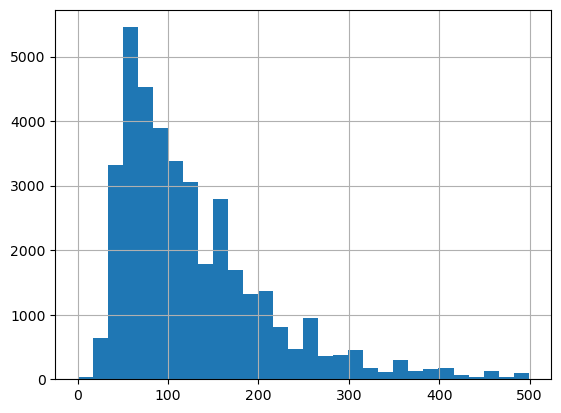

In [37]:
df[df.price < 500].price.hist(bins=30);

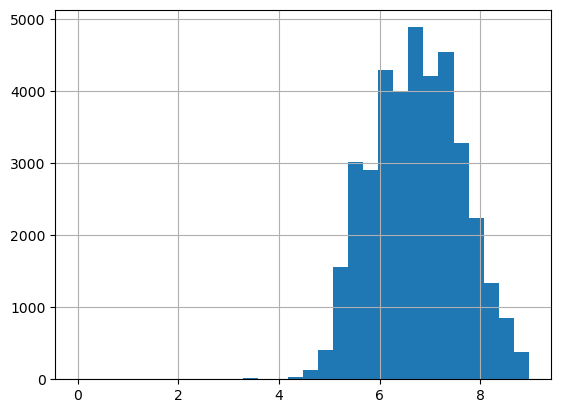

In [38]:
np.log2(abs(df[df.price < 500].price)+1).hist(bins=30);

### Непараметрические тесты

#### Тест Манна-Уитни

Критерий Манна-Уитни представляет непараметрическую альтернативу критерию Стьюдента для независимых выборок и используется для оценки раздичий между двумя независимыми выборками по уровню какого-либо празнака, измеренного количественно.

Допущения
- Наблюдения внутри каждой выборки независимы доуг от друга.
- Наблюдения можно проранжировать.

Гипотеза
- Н0: Распределения одинаковы.
- Н1: Распределения различаются.

In [39]:
data1 = [0.837, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]
data2 = [1.142, -0.432, -0.938, -0.729, -0.846, -0.157, 0.500, 1.183, -1.075, -0.169]

stat, p = st.mannwhitneyu(data1, data2)

print(f'Статистика = {stat:.5f}, p = {p:.5f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вроятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, раздичаются')

Статистика = 40.00000, p = 0.47268
Не отклоняем нулевую гипотезу, распределения, вроятно, одинаковые


#### Тест Вилкоксона

Тест Вилкоксона - это непараметрический аналог пароно критерия Стьюдента.

Допущения
- Наблюдения внутри каждой выборки назависимы друг от друга.
- Наболюдения можно проранжировать.
- Наблюдения связаны попарно в двух выборках.

Гипотеза
- Н0: Две связанные выборки принадленат отному распределению.
- Н1: Дву связанные выборки принадленат разным распределениям.

In [40]:
data1 = [0.837, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]
data2 = [1.142, -0.432, -0.938, -0.729, -0.846, -0.157, 0.500, 1.183, -1.075, -0.169]

stat, p = st.wilcoxon(data1, data2)

print(f'Статистика = {stat:.5f}, p = {p:.5f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вроятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, раздичаются')

Статистика = 21.00000, p = 0.55664
Не отклоняем нулевую гипотезу, распределения, вроятно, одинаковые


In [41]:
# Этот тест можно применить только к столбцу разница (dif)
dif = np.array(data1) - np.array(data2)

stat, p = st.wilcoxon(dif)

print(f'Статистика = {stat:.5f}, p = {p:.5f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вроятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, раздичаются')

Статистика = 21.00000, p = 0.55664
Не отклоняем нулевую гипотезу, распределения, вроятно, одинаковые


### Тесты, работающие с категориальными данными

#### Точный критерий Фишера

Критерий Стьюдента позволяет работать с численными переменными, но не позволяет работать с категориальными. Для этого существует критерий Фишера (или Хи-квадрат). Одна из его задач сказать, насколько слуяайно распределены значения между группами. Позволяет проверить гипотезу, есть ли значимый перевес между группами.

Допущения
- Наблюдения независимы друг от друга.
- Встречаются ограничения на минимальное число набрюдений.

Гипотеза
- Н0: Выборки назевисимы.
- Н1: Есть некоторая зависимость.

**Пример** Хотим проверить, нет ли дискриминации по половому признаку в сфере Data Science. Есть информация, что в какой-то компании после серии собеседований 107 мужчин взяли на работу, а 93-м отказали. А среди женщин 74 взяли, а отказали 45-и. Относится ли руководство компании предвзято к мужчинам или к женщинам?

In [42]:
x = [[107, 93], [74, 45]]

oddsratio, p = st.fisher_exact(x) # Точный тест Фишера

print(f'Статистика = {oddsratio:.5f}, p = {p:.5f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, выборки, вероятно, независимы')
else:
    print('Отклоняем нулевую гипотезу, вероятно, есть некоторая зависимость')

Статистика = 0.69965, p = 0.16076
Не отклоняем нулевую гипотезу, выборки, вероятно, независимы


#### Тест Хи-квадрат

Например, вы хотите проверить правда ли эксперт по Data Science таковым является. Вы составили список вопросов, спросили эксперта и случайных прохожих. Количество правильных ответов по каждому разделу вы записали в таблицу (таблица смежности)

Выясните, исходя из полученных данных, действительно ли перед вами носитель экспертности или пока что еще на очень опытный начинающий?

In [43]:
contingency_table = pd.DataFrame(
    [
        [22, 99, 59],
        [10, 12, 31]
    ],
    columns = ['Machine Learning', 'Data Science', 'Analytics'],
    index = ['Эксперт', 'Случайный прохожий']
)

print('Реальная таблица')
print(contingency_table)

Реальная таблица
                    Machine Learning  Data Science  Analytics
Эксперт                           22            99         59
Случайный прохожий                10            12         31


In [44]:
chi, pval, dof, exp = st.chi2_contingency(contingency_table.values) # Критерий Пирсона (хи-квадрат)
significance = 0.05

print(f'p-value = {pval:.6f}, уровень значимости = {significance:.2f}')
if pval < significance:
    print(f'На уровне значимости {significance:.2f} мы отвергаем нулевую гипотезу и принимает Н1. Они не зависимы.')
    print('Это и првда эксперт!')
else:
    print(f'На уровне значимости {significance:.2f} мы не отвергаем нулевую гипотезу. Они зависимы.')

            

p-value = 0.000173, уровень значимости = 0.05
На уровне значимости 0.05 мы отвергаем нулевую гипотезу и принимает Н1. Они не зависимы.
Это и првда эксперт!


## Дисперсионный анализ

### Рассчет вручную

In [45]:
# Выборки, которые надо сравнить
data = pd.DataFrame(
    {
        "a": [3, 1, 2],
        "b": [5, 3, 4],
        "c": [7, 6, 5],
    }
)

data

,a,b,c
0,3,5,7
1,1,3,6
2,2,4,5


Нулевая гипотеза: a=b=c
Альтернативная гипотеза: !(a=b=c)


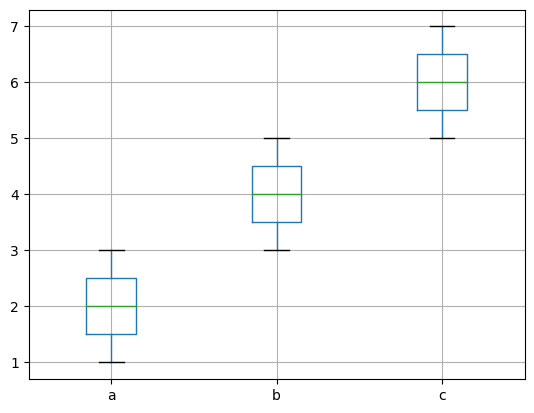

In [46]:
data.boxplot()
print('Нулевая гипотеза:', '='.join(data))
print('Альтернативная гипотеза:', f'!({"=".join(data)})')

#### Вычисляем общее среднее

In [47]:
data.values

array([[3, 5, 7],
       [1, 3, 6],
       [2, 4, 5]])

In [48]:
# Переводим матрицу в одно измерение
data.values.flatten()

array([3, 5, 7, 1, 3, 6, 2, 4, 5])

In [49]:
# Общая средняя
grand_mean = data.values.flatten().mean()
grand_mean

4.0

#### Вычисляем общую сумму квадратов sst = ssb + ssw

In [50]:
# Список квадратов отклонений от общего среднего
[(val - grand_mean)**2 for val in data.values.flatten()]

[1.0, 1.0, 9.0, 9.0, 1.0, 4.0, 4.0, 0.0, 1.0]

In [51]:
# Сумма квадратов отклонений от общего среднего
sst = sum((val - grand_mean)**2 for val in data.values.flatten())
sst

30.0

#### Формула рассчета разброса между группами (ssb)

In [52]:
list(data.mean().items())

[('a', 2.0), ('b', 4.0), ('c', 6.0)]

In [53]:
[(group, group_mean) for group, group_mean in data.mean().items()]

[('a', 2.0), ('b', 4.0), ('c', 6.0)]

In [54]:
data['a'].size

3

In [55]:
[data[group].size * (group_mean - grand_mean) ** 2 for group, group_mean in data.mean().items()]

[12.0, 0.0, 12.0]

In [56]:
# Отклонение групповых средних от общей средней
ssb = sum(data[group].size * (group_mean - grand_mean) ** 2 for group, group_mean in data.mean().items())
ssb

24.0

#### Формула рассчета разброса внутри каждой группы (ssw)

In [57]:
# Отклонения значений внутри группы от средней группы
ssw = sum(sum((x - group_mean)**2 for x in data[group]) for group, group_mean in data.mean().items())
ssw

6.0

#### Степени свободы

In [58]:
groups = data.shape[1]
groups

3

In [59]:
dfb = groups - 1
dfw = data.size - groups

In [60]:
dfb

2

In [61]:
dfw

6

#### Межгрупповой средний квадрат

In [62]:
mssb = ssb/dfb
mssb

12.0

#### Внутригрупповой средний квадрат

In [63]:
mssw = ssw/dfw
mssw

1.0

#### Рассчитываем f-значение

In [64]:
f_value = mssb/mssw
f_value

12.0

#### Рассчитаем p-value

In [65]:
p = st.f.sf(f_value, dfb, dfw)
print('Результат:')
print(f'p-value = {p}')
if p < 0.05:
    print('Отклоняем нулевую гипотезу')
else:
    print('НЕ отклоняем нулевую гипотезу')
print(f'Полученное f-значение {f_value}')


Результат:
p-value = 0.008000000000000002
Отклоняем нулевую гипотезу
Полученное f-значение 12.0


### Используем встроенные функции питона

#### Однофакторный одномерный дисперсионный анализ

Проанализируем синтерический датасет с данными. У насть есть наблюдения по 4 группам. Предположим, сто это данные о результатах исследования эффективности четырех препаратов и нам нужно определить есть ли между этими результатами статистически значимая разница.

In [66]:
df = pd.DataFrame(
    [
        [25, 45, 30, 54],
        [30, 55, 29, 60],
        [28, 29, 33, 51],
        [36, 56, 37, 62],
        [29, 40, 27, 73],
    ],
    columns=['A', 'B', 'C', 'D']
)
df

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


In [67]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
df_melt.columns = ['index', 'treatments', 'value']
df_melt

,index,treatments,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29
5,0,B,45
6,1,B,55
7,2,B,29
8,3,B,56
9,4,B,40


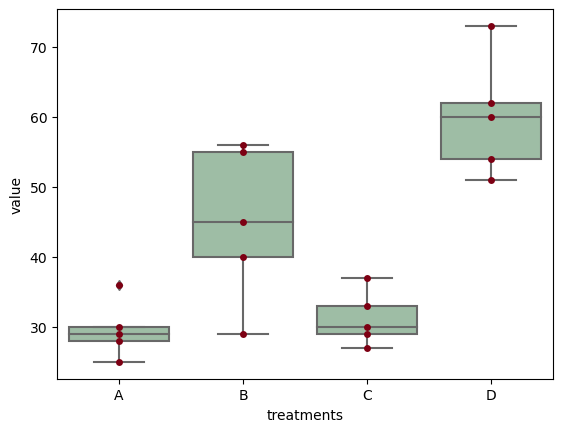

In [68]:
ax = sns.boxplot(x='treatments', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x='treatments', y='value', data=df_melt, color='#7d0013')
plt.show()

In [70]:
fvalue, pvalue = st.f_oneway(df['A'], df['B'], df['C'], df['D'])

print(f'Статистика = {fvalue:.3f}, p-value = {pvalue:.6f}')
if pvalue > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняет нулевую гипотезу, средние, вероятно, различаются')

Статистика = 17.493, p-value = 0.000026
Отклоняет нулевую гипотезу, средние, вероятно, различаются


#### Анализ мощности

возможные задачи:
- по заранее определенной точности, по альфа и по бете рассчитать, сколько нужно будет данных
- при наличии фиксированного количества данных рассчитать бету при фиксированной альфе.

In [77]:
# для t-теста это функция tt_solve_power
tt_solve_power(
    effect_size = 0.2,
    alpha = 0.01, 
    power = 0.95
)

448.67785943065195

Для каждого теста есть свой метод анализа мощности!!!

#### Поправка Тьюке

In [79]:
df

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


In [83]:
groups = ['A', 'B', 'C', 'D']
names = [];
for k1 in range (len(groups)):
    for k2 in range(len(df['A'])):
        names.append(groups[k1])

In [85]:
names

['A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'B',
 'B',
 'B',
 'C',
 'C',
 'C',
 'C',
 'C',
 'D',
 'D',
 'D',
 'D',
 'D']

In [91]:
tukey = pairwise_tukeyhsd(
    endog=pd.concat([df['A'], df['B'], df['C'], df['D']]).values,
    groups = names,
    alpha = 0.05
)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B     15.4 0.0251   1.694 29.106   True
     A      C      1.6 0.9867 -12.106 15.306  False
     A      D     30.4 0.0001  16.694 44.106   True
     B      C    -13.8 0.0482 -27.506 -0.094   True
     B      D     15.0 0.0296   1.294 28.706   True
     C      D     28.8 0.0001  15.094 42.506   True
---------------------------------------------------


In [93]:
# можно и так:
tukey = pairwise_tukeyhsd(
    endog=pd.concat([df['A'], df['B'], df['C'], df['D']]).values,
    groups = df_melt['treatments'],
    alpha = 0.05
)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B     15.4 0.0251   1.694 29.106   True
     A      C      1.6 0.9867 -12.106 15.306  False
     A      D     30.4 0.0001  16.694 44.106   True
     B      C    -13.8 0.0482 -27.506 -0.094   True
     B      D     15.0 0.0296   1.294 28.706   True
     C      D     28.8 0.0001  15.094 42.506   True
---------------------------------------------------


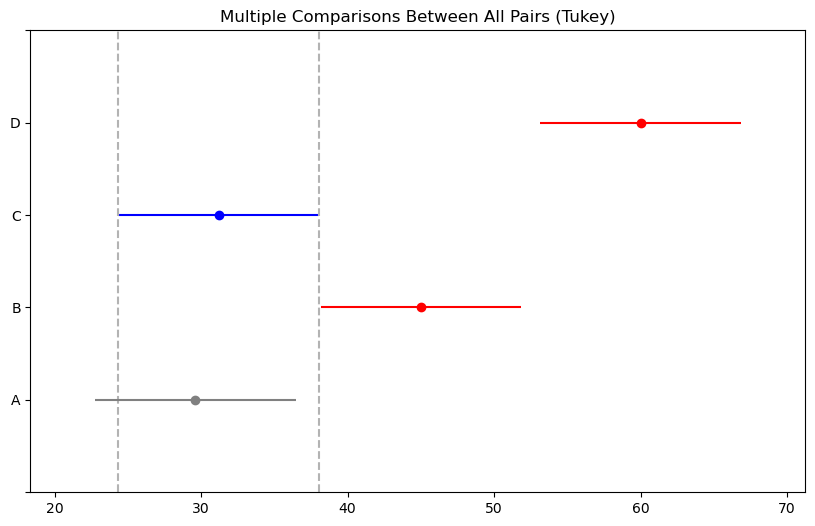

In [95]:
# визуализация метода Тьюке
tukey.plot_simultaneous(comparison_name='C');

## Тест Краскела-Уоллиса

Непараметрический аналог одномерного дисперсионного анализа. Он используется для сравнения трех или более выборок, и проверяет гипотезы, согласно которым различные выборки были взяты из одного и того же рапределения, или из распределений с одинаковыми медианами.

Допущения
- Наблюдения независимы друг от друга.
- Наблюдения можно проранжировать.

Гипотеза
- Н0: Все распределения одинаковы.
- Н1: Одно или несколько расеределений различаются.

In [96]:
data1 = [6.873, 4.817, 4.121, -0.045, -0.055, -0.0436, 4.360, -0.478, -0.0637, -0.089]
data2 = [1.142, -0.432, -0.938, -0.729, -0.846, -0.157, 0.500, 1.183, -1.075, -0.169]
data3 = [-0.208, 0.696, 0.928, -1.148, -0.213, 0.229, 0.137, 0.269, -0.870, -1.204]

In [97]:
# метод Краскала-Уоллиса
stat, p = st.kruskal(data1, data2, data3)

print(f'Статистика = {stat:.3f}, p-value = {p:.3f}')
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинатовые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика = 4.328, p-value = 0.115
Не отклоняем нулевую гипотезу, распределения, вероятно, одинатовые


#### Правка Дунна (аналогичный правке Тьюке)

In [108]:
#sp.posthoc_dunn(data, p_adjust = 'bonferroni')

## Тесты на нормальность данных

### Тест Шапиро-Уилка

Проверяет, распределены ли данные по нормальному закону.

Допущения
- Наблюдение независимы друг от друга.

Гипотеза
- Н0: Данные распределены по нормальному закону.
- Н1: Данные не распределены по нормальному закону.

In [109]:
data = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]

In [110]:
stat, p = st.shapiro(data)

print(f'Статистика = {stat:.3f}, p-value = {p:.3f}')
if p > 0.05:
    print('Вероятно нормальное распределение')
else:
    print('Вероятно не номальное распределение')

Статистика = 0.895, p-value = 0.193
Вероятно нормальное распределение


### Тест Андерсона-Дарлинга

Проверяет, распределены ли данные по нормальному закону.

Допущения
- Наблюдение независимы друг от друга.

Гипотеза
- Н0: Данные распределены по нормальному закону.
- Н1: Данные не распределены по нормальному закону.

In [111]:
result = st.anderson(data)
result

AndersonResult(statistic=0.4239737141854789, critical_values=array([0.501, 0.57 , 0.684, 0.798, 0.95 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.32489999999999997, scale=1.4568542556557338)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [112]:
print(f'stat = {result.statistic:.3f}')
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f'Вероятно, нормальное расеределение на уровне {sl:.1f} ')
    else:
        print(f'Вероятно, не нормальное распределение на уровне {sl:.1f}')

stat = 0.424
Вероятно, нормальное расеределение на уровне 15.0 
Вероятно, нормальное расеределение на уровне 10.0 
Вероятно, нормальное расеределение на уровне 5.0 
Вероятно, нормальное расеределение на уровне 2.5 
Вероятно, нормальное расеределение на уровне 1.0 


### Тест Колмогорова-Смирнова

In [113]:
data3 = np.random.normal(0, 1, 100)
data4 = np.random.normal(5, 2, 100)
data5 = np.random.normal(5, 2.1, 100)

In [115]:
data

[0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.36, -1.478, -1.637, -1.869]

In [116]:
stat, p = st.kstest(data, 'norm')
print(f'Статистика = {stat:.5f}, p-value = {p:.15f}')

Статистика = 0.32767, p-value = 0.186135327199016


In [119]:
stat, p = st.kstest(data3, 'norm')
print(f'Статистика = {stat:.5f}, p-value = {p:.15f}')

Статистика = 0.09772, p-value = 0.276837557613757


Сравним два распределения:

In [120]:
data1 = np.random.randn(100)
data2 = np.random.lognormal(3, 1, 100)

In [121]:
stat, p = st.ks_2samp(data1, data2)
print(f"Статистика = {stat:.5f}, p-value = {p:.5f}")

Статистика = 1.00000, p-value = 0.00000
